# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></div><div class="lev1 toc-item"><a href="#Manipulate-data" data-toc-modified-id="Manipulate-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Manipulate data</a></div><div class="lev1 toc-item"><a href="#Question:-Are-the-three-diets-equally-effective-for-weight-loss?" data-toc-modified-id="Question:-Are-the-three-diets-equally-effective-for-weight-loss?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Question: Are the three diets equally effective for weight loss?</a></div><div class="lev1 toc-item"><a href="#Visualize-diet-vs-weight-loss" data-toc-modified-id="Visualize-diet-vs-weight-loss-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualize diet vs weight loss</a></div><div class="lev1 toc-item"><a href="#Tukey-Test" data-toc-modified-id="Tukey-Test-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tukey Test</a></div>

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 8]
plt.style.use('fivethirtyeight')
%matplotlib inline

import scipy.stats as stats

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

%load_ext version_information
%version_information numpy,scipy,pandas,sklearn,matplotlib,seaborn,statsmodels,plotly

Software,Version
Python,3.5.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython,7.4.0
OS,Darwin 14.5.0 x86_64 i386 64bit
numpy,1.11.0
scipy,0.19.0
pandas,0.20.0
sklearn,0.18.1
matplotlib,2.0.0
seaborn,0.7.1
statsmodels,0.8.0


# Load data

Ref: https://raiswell.rbind.io/post/one-way-anova-in-python/

This data comes from the University of Sheffield in the UK. It is listed as an “R Dataset” but it is a .csv text file, which Python pandas can import with no problems at all. When I began on these notes I didn’t realize that the University also has an ANOVA lesson based on this data. You can access the very useful R-based [notes here](https://www.sheffield.ac.uk/polopoly_fs/1.536445!/file/MASH_ANOVA_in_R.pdf).

“The data set Diet.csv contains information on 78 people who undertook one of three diets. There is background information such as age, gender (Female=0, Male=1) and height. The aim of the study was to see which diet was best for losing weight so the independent variable (group) is diet.” - The University of Sheffield’s Mathematics and Statistics Help Department (MASH)

In [6]:
# infile = "https://www.sheffield.ac.uk/polopoly_fs/1.570199!/file/stcp-Rdataset-Diet.csv" 
infile = 'stcp-Rdataset-Diet.csv'
df = pd.read_csv(infile,nrows=None,skiprows=None,sep=',')
print(df.shape)
df.head(2).append(df.tail(2))

(78, 7)


,Person,gender,Age,Height,pre.weight,Diet,weight6weeks
0,25,,41,171,60,2,60.0
1,26,,32,174,103,2,103.0
76,77,1,40,167,87,3,77.8
77,78,1,51,175,88,3,81.9


# Manipulate data

In [10]:
df['Loss'] = df['pre.weight'] - df['weight6weeks'] # creates a target variable of weight loss. 
df.head()

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks,Loss
0,25,,41,171,60,2,60.0,0.0
1,26,,32,174,103,2,103.0,0.0
2,1,0,22,159,58,1,54.2,3.8
3,2,0,46,192,60,1,54.0,6.0
4,3,0,55,170,64,1,63.3,0.7


In [15]:
df.Loss.describe()

count    78.000000
mean      3.844872
std       2.551478
min      -2.100000
25%       2.000000
50%       3.600000
75%       5.550000
max       9.200000
Name: Loss, dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 8 columns):
Person          78 non-null int64
gender          78 non-null object
Age             78 non-null int64
Height          78 non-null int64
pre.weight      78 non-null int64
Diet            78 non-null int64
weight6weeks    78 non-null float64
Loss            78 non-null float64
dtypes: float64(2), int64(5), object(1)
memory usage: 5.0+ KB


In [7]:
# make Diet column categorical
df['Diet'] = pd.Categorical(df.Diet)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 7 columns):
Person          78 non-null int64
gender          78 non-null object
Age             78 non-null int64
Height          78 non-null int64
pre.weight      78 non-null int64
Diet            78 non-null category
weight6weeks    78 non-null float64
dtypes: category(1), float64(1), int64(4), object(1)
memory usage: 3.9+ KB


# Question: Are the three diets equally effective for weight loss?

ANOVA cannot prove causation. It can tell us whether the mean weight loss of each diet group are different at a statistically significant level. In this case, our null hypothesis is that all group mean weight losses are the same.

We start by visualizing the impact of each diet on the weight loss variable with a box plot. We use the Seaborn data visualization package. Figure 1 tells us that Diet 3 seems to be the most effective; it has the highest mean weight loss. The standard deviations of each diet look similar.

Analysis of Variance or ANOVA tells us whether the differences in the variance between each diet group are statistically significant when compared to the differences within each group.

One of the core assumptions with ANOVA is that the dependent variable is normally distributed.

$$
H _ { 0 } : \mu _ { 1 } = \mu _ { 2 } = \mu _ { 3 }
$$

$$
H _ { a } : \mu _ { i } \neq \mu _ { j } \text{ for at least one i or j}
$$ 

# Visualize diet vs weight loss

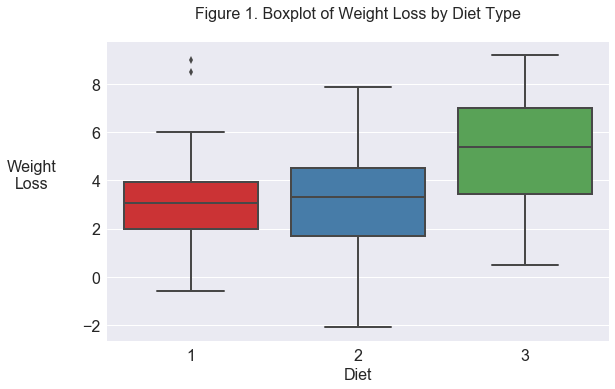

In [12]:
sns.set(font_scale=1.6)
ax = sns.boxplot(x = "Diet", y = "Loss", data = df, 
                 palette="Set1", 
                 linewidth = 2) 

ax.set_title("Figure 1. Boxplot of Weight Loss by Diet Type\n", fontsize=16) 
ax.set_ylabel("Weight\nLoss", rotation = 0, fontsize=16, labelpad=50)
ax.set_xlabel("Diet", rotation = 0, fontsize=16)
plt.show()

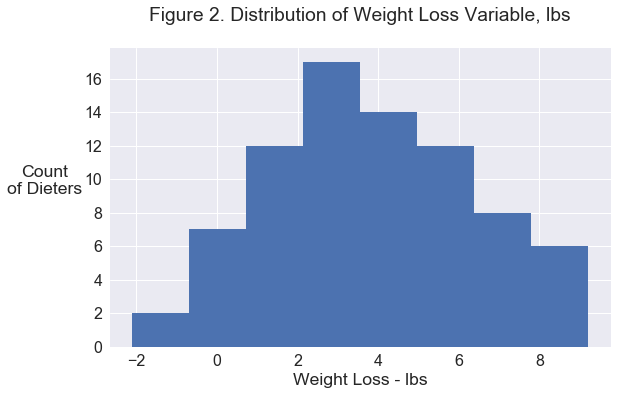

In [14]:
plt.hist(df['Loss'], bins='auto') # check for variable normality in weight loss dependent variable. 

# Data looks normally distributed.
plt.title("Figure 2. Distribution of Weight Loss Variable, lbs\n")
plt.xlabel("Weight Loss - lbs")
plt.ylabel("Count\nof Dieters", rotation = 0, labelpad = 40)
plt.show()

We now confirm our intuition from the visualization that the weight loss data is normally distributed. The p-score is higher than our alpha of 0.05, showing our intuition to be correct.

In [21]:
print(stats.normaltest(df['Loss'], axis=0))

NormaltestResult(statistic=0.82560326837248943, pvalue=0.66179354702374682)


In [22]:
# P > 0.05 therefore We cannot reject the hypothesis that the sample comes
# from a population which has a normal distribution

In [23]:
# Now we create an Ordinary Least Squares (OLS) model as a precursor to the ANOVA.

In [26]:
model = smf.ols("Loss ~ Diet", df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Loss   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     6.197
Date:                Fri, 28 Jun 2019   Prob (F-statistic):            0.00323
Time:                        14:25:49   Log-Likelihood:                -177.27
No. Observations:                  78   AIC:                             360.5
Df Residuals:                      75   BIC:                             367.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3000      0.489      6.750      0.000       2.326       4.274
Diet[T.2]     -0.2741      0.672     -0.408      0.684      -1.613       1.064
Diet[T.3]      1.8481      0.672      2.751      0.007       0.510       3.187
==============================================================================
Omnibus:                        0.064   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.968   Jarque-Bera (JB):                0.230
Skew:                           0.036   Prob(JB):                        0.891
Kurtosis:                       2.744   Cond. No.                         3.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# Before the ANOVA, we check the OLS residuals are normally distributed.
# This is another important prior assumption. The residuals look approximately normal.

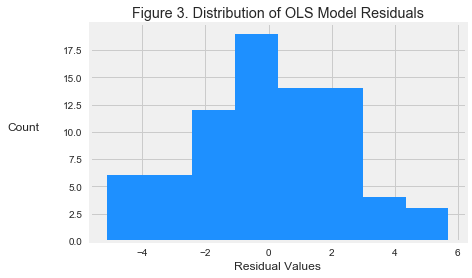

In [30]:
resids = statsmodels.regression.linear_model.RegressionResults.resid(model) # grabs the residual values from the OLS model
hist2 = plt.hist(resids, bins = 'auto', color='dodgerblue') # check for variable normality in weight loss dependent variable. 
plt.title("Figure 3. Distribution of OLS Model Residuals")
plt.xlabel("Residual Values")
plt.ylabel("Count", rotation = 0, labelpad = 40)
plt.show()

In [33]:
resids2 = model.resid
np.allclose(resids,resids2)

True

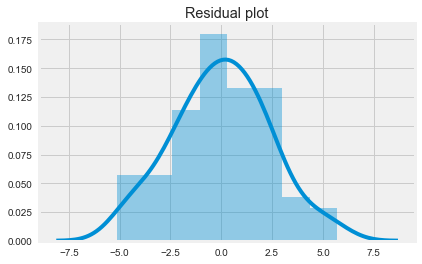

In [37]:
sns.distplot(resids2)
plt.title('Residual plot')

In [38]:
print(stats.normaltest(resids, axis=0))

NormaltestResult(statistic=0.064394351016517304, pvalue=0.96831563512727403)


In [39]:
# P > 0.05 therefore We cannot reject the hypothesis that the sample comes
# from a population which has a normal distribution

We now call the ANOVA function, applying it to the linear model. We are looking for a p-score lower than 0.05, which will show a statistically significant difference between mean weight losses. It will not tell us where those differences exist, just whether they exist. The p-score of 0.003229 shows that they do.

In [40]:
table = sm.stats.anova_lm(model, typ=2) # Type 2 ANOVA test
print(table) 

# In a one-way ANOVA the null hypothesis is that the means of the Diet types are equal.
# We can reject that hypothesis
# because P < 0.05 

              sum_sq    df         F    PR(>F)
Diet       71.093689   2.0  6.197447  0.003229
Residual  430.179259  75.0       NaN       NaN


# Tukey Test

But which diet is the best one for weight loss?  
This question is out of the scope of the ANOVA, though our analysis is an
important precursor to answering this more specific question.

We can check with a post hoc Tukey test.

It looks like the Diet 3 group lost the most weight. 

The second row of results shows a 1.85 mean difference in weight loss between Diets 2 and 3. 

The third row shows the mean difference for those on Diet 2 after we subtract the second row results from it: 2.12 - 1.85 = 0.27. 

So the Diet 2 group only lost an average of 0.27 lbs more than the Diet 1 group.

Again, let me stress that this is not a definitive causal analysis.

All we have established is that the three dieting groups differ in weight loss performance from one another, and by what average margin.

There may well be other confounding factors at play causing the weight loss.

In [42]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [44]:
mc = MultiComparison(df['Loss'], df['Diet'])
tkresult = mc.tukeyhsd()
 
print(tkresult)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2    -0.2741  -1.8806 1.3325 False 
  1      3     1.8481   0.2416 3.4547  True 
  2      3     2.1222   0.5636 3.6808  True 
--------------------------------------------
[1 2 3]


In [47]:
# WRONG: muGroup1 - muGroup2 = -0.07
# RIGHT: muGroup2 - muGroup1 = -0.07   Always read WRONG way SECOND - FIRST

# a = diet1 b = diet2 c = diet3
# a > b  NOTE: Read WRONG way, if meandiff is negative group1 has higher mean
# c > a 
# c > b 

# c > a > b
# c is best, diet3 is best.